<a href="https://colab.research.google.com/github/hiteshidudeja/Project_cifar10/blob/main/Project_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [ ]:
def unpickle(file):
  with open(file, 'rb') as fo:
      dictt = pickle.load(fo, encoding='bytes')
  return dictt

In [ ]:
dict1 = unpickle('/content/data_batch_1')
dict2 = unpickle('/content/data_batch_2')
dict3 = unpickle('/content/data_batch_3')
dict4 = unpickle('/content/data_batch_4')
dict5 = unpickle('/content/data_batch_5')
test = unpickle('/content/test_batch')

# **Using Neural Network**

In [ ]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())


Extracting data/cifar-10-python.tar.gz to data/


# Exploring the Dataset

In [ ]:
type(dataset)

torchvision.datasets.cifar.CIFAR10

In [ ]:
dataset_size = len(dataset)
dataset_size

50000

In [ ]:
len(test_dataset)

10000

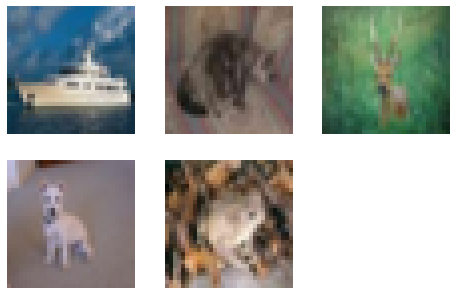

In [ ]:
figure = plt.figure(figsize=(8, 8))
rows, cols= 3, 3
for i in range(1, 6):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.permute((1, 2, 0)))

# Validation and Training Set

In [ ]:
torch.manual_seed(43)

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size
train_size

45000

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [ ]:
train_ds

In [ ]:
batch_size=200

In [ ]:
""" Dividing the data into training , validation and testing data """
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)       
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(train_loader)

225

In [ ]:
len(val_loader)

25

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([200, 3, 32, 32])


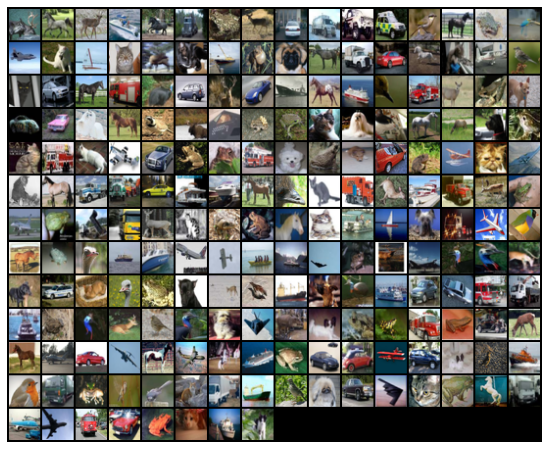

In [ ]:
""" Plotting images present in one training batch """
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Training

In [ ]:
def accuracy(outputs, labels):
    _, predic = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predic == labels).item() / len(predic))

In [ ]:
class ImgClassiBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.is_available()

False

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
def plot_losses(outp):                                                          #plots loss vs number of epochs 
    losses = [x['val_loss'] for x in outp]                                 
    plt.plot(losses, '-x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(outp):                                                      #plots accuracy vs no. of epochs
    accuracies = [x['val_acc'] for x in outp]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
""" Neural Network with 4 layers . Each hidden layer uses Relu function for activation."""
class CIFAR10Model(ImgClassiBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3*32*32, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 512)
        self.linear4 = nn.Linear(512, 10)
  
        
    def forward(self, xb):
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out

In [ ]:
model = to_device(CIFAR10Model(), device)                                       #Creating the model

# Testing

In [ ]:
outp = [evaluate(model, val_loader)]                                            #Evaluating the model on validation data 
outp

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09080000221729279, 'val_loss': 2.3037941455841064}]

In [ ]:
outp += fit(10,0.01, model, train_loader, val_loader, torch.optim.Adam)         #Fitting the model having learning rate =0.01, number of epochs=10, optimiser used = Adam

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.9062, val_acc: 0.3046
Epoch [1], val_loss: 1.7902, val_acc: 0.3534
Epoch [2], val_loss: 1.7920, val_acc: 0.3508
Epoch [3], val_loss: 1.7416, val_acc: 0.3750
Epoch [4], val_loss: 1.7563, val_acc: 0.3626
Epoch [5], val_loss: 1.7406, val_acc: 0.3752
Epoch [6], val_loss: 1.6808, val_acc: 0.3876
Epoch [7], val_loss: 1.7040, val_acc: 0.3862
Epoch [8], val_loss: 1.6890, val_acc: 0.3888
Epoch [9], val_loss: 1.7026, val_acc: 0.3902


In [ ]:
outp += fit(20, 0.001 , model, train_loader, val_loader, torch.optim.Adam)      #Fitting the model having learning rate =0.001, number of epochs=20, optimiser used = Adam

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.6056, val_acc: 0.4182
Epoch [1], val_loss: 1.6048, val_acc: 0.4196
Epoch [2], val_loss: 1.6075, val_acc: 0.4208
Epoch [3], val_loss: 1.6041, val_acc: 0.4240
Epoch [4], val_loss: 1.5944, val_acc: 0.4278
Epoch [5], val_loss: 1.6062, val_acc: 0.4256
Epoch [6], val_loss: 1.5960, val_acc: 0.4352
Epoch [7], val_loss: 1.5981, val_acc: 0.4332
Epoch [8], val_loss: 1.5896, val_acc: 0.4326
Epoch [9], val_loss: 1.5936, val_acc: 0.4270
Epoch [10], val_loss: 1.5985, val_acc: 0.4320
Epoch [11], val_loss: 1.5989, val_acc: 0.4266
Epoch [12], val_loss: 1.5852, val_acc: 0.4342
Epoch [13], val_loss: 1.5830, val_acc: 0.4320
Epoch [14], val_loss: 1.5900, val_acc: 0.4282
Epoch [15], val_loss: 1.5764, val_acc: 0.4346
Epoch [16], val_loss: 1.5877, val_acc: 0.4332
Epoch [17], val_loss: 1.6166, val_acc: 0.4282
Epoch [18], val_loss: 1.6022, val_acc: 0.4300
Epoch [19], val_loss: 1.5818, val_acc: 0.4298


In [ ]:
outp += fit(10, 0.00001, model, train_loader, val_loader, torch.optim.Adam)       #Fitting the model having learning rate =0.0001, number of epochs=10, optimiser used = Adam

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.5760, val_acc: 0.4380
Epoch [1], val_loss: 1.5754, val_acc: 0.4390
Epoch [2], val_loss: 1.5754, val_acc: 0.4406
Epoch [3], val_loss: 1.5751, val_acc: 0.4408
Epoch [4], val_loss: 1.5752, val_acc: 0.4388
Epoch [5], val_loss: 1.5749, val_acc: 0.4390
Epoch [6], val_loss: 1.5752, val_acc: 0.4394
Epoch [7], val_loss: 1.5750, val_acc: 0.4404
Epoch [8], val_loss: 1.5752, val_acc: 0.4394
Epoch [9], val_loss: 1.5749, val_acc: 0.4410


In [ ]:
evaluate(model, test_loader)                                                     #Evaluating the model on test data 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.4511999487876892, 'val_loss': 1.533871054649353}

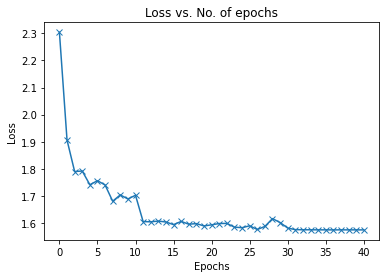

In [ ]:
plot_losses(outp)

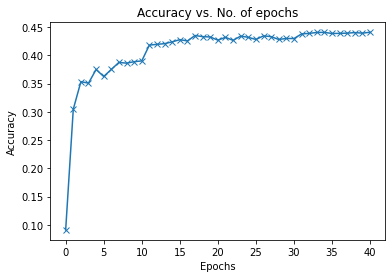

In [ ]:
plot_accuracies(outp)

# **Using K-Nearest Neighbor Classifier**

### Constructing Feature DataFrame (including Data-Preprocessing such as Standardization and Min-Maximization) and Label DataFrame

In [ ]:
X_train = pd.DataFrame(np.concatenate((dict1[b'data'],dict2[b'data'],dict3[b'data'],dict4[b'data'],dict5[b'data']),axis = 0),columns = [i for i in range(0,3072)])
Y_train = pd.DataFrame(np.concatenate((np.array(dict1[b'labels']),np.array(dict2[b'labels']),np.array(dict3[b'labels']),np.array(dict4[b'labels']),np.array(dict5[b'labels']))),columns = ['Class'])
X_test = pd.DataFrame(test[b'data'],columns = [i for i in range(0,3072)])
Y_test = pd.DataFrame(np.array(test[b'labels']),columns = ['Class'])

X = pd.concat([X_train,X_test])          # Combined Train and Test Data for Normalization Techniques and Visualisation Purposes
X = X.reset_index(drop=True)

Y = pd.concat([Y_train,Y_test])          # Combined Train and Test Labels for Visualisation Purposes
Y = Y.reset_index(drop=True)

sx = pd.DataFrame((StandardScaler().fit(X)).transform(X),columns = X.columns)          # Standardization of Features
mx = pd.DataFrame((MinMaxScaler().fit(X)).transform(X),columns = X.columns)          # Min-Maximization of Features

### Principal Component Analysis for Visualization Purposes

In [ ]:
visual1 = (PCA(n_components=2).fit(X)).transform(X)          # Transforming Original Features into 2-D Information
visual2 = (PCA(n_components=2).fit(sx)).transform(sx)          # Transforming Standardized Features into 2-D Information
visual3 = (PCA(n_components=2).fit(mx)).transform(mx)          # Transforming Min-Maximised Features into 2-D Information

### Label-Wise Scatter Distribution Plot for Datapoints (With variation in Data-Preprocessing Techniques)

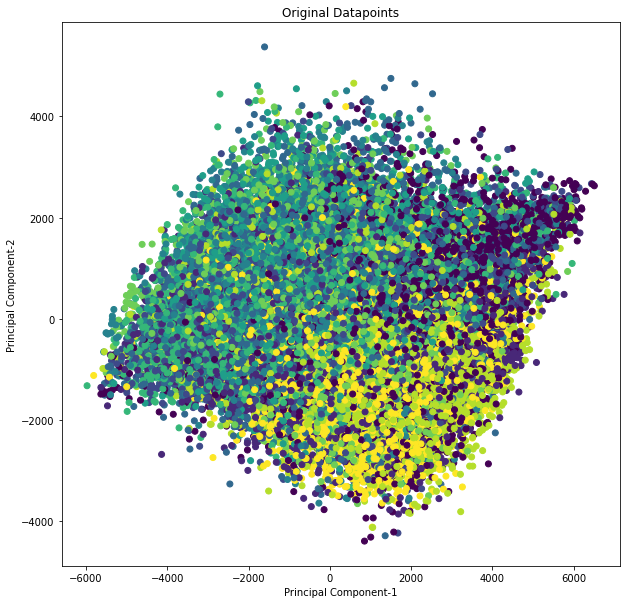

In [ ]:
# Visualization for Original Datapoints

plt.figure(figsize=(10,10))
plt.scatter(visual1[:,0],visual1[:,1],c=Y.to_numpy())
plt.xlabel('Principal Component-1')
plt.ylabel('Principal Component-2')
plt.title('Original Datapoints')
plt.show()

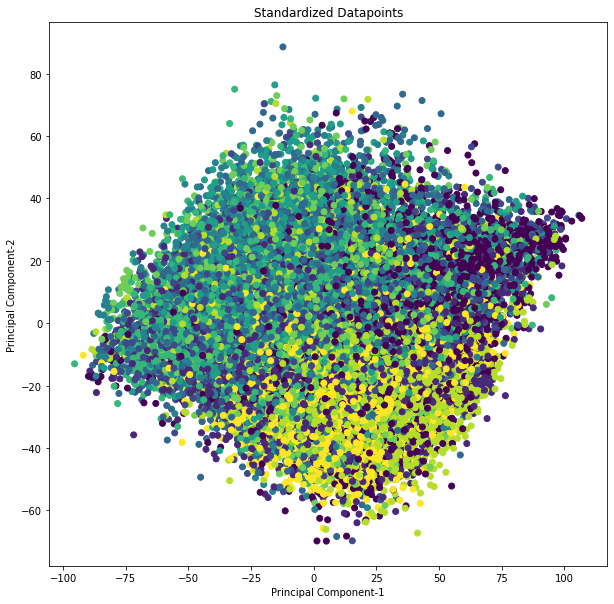

In [ ]:
# Visualization for Standardized Datapoints

plt.figure(figsize=(10,10))
plt.scatter(visual2[:,0],visual2[:,1],c=Y.to_numpy())
plt.xlabel('Principal Component-1')
plt.ylabel('Principal Component-2')
plt.title('Standardized Datapoints')
plt.show()

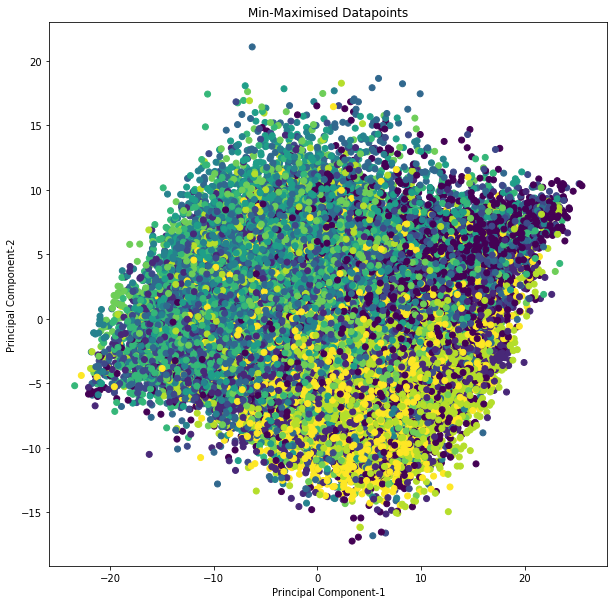

In [ ]:
# Visualization for Min-Maximised Datapoints

plt.figure(figsize=(10,10))
plt.scatter(visual3[:,0],visual3[:,1],c=Y.to_numpy())
plt.xlabel('Principal Component-1')
plt.ylabel('Principal Component-2')
plt.title('Min-Maximised Datapoints')
plt.show()

## KNN Classification without Transforming Data and simultaneously keeping each pixel column

### Train-Validation Splitting by Stratified K-Fold Technique

In [ ]:
skfo = SKF()
idxo = skfo.split(X_train,Y_train)          # Stratified K-Fold Split for Original Non-Transformed Datapoints
for train, val in idxo:
    Xtro,Ytro = X_train.iloc[train,:],Y_train.iloc[train,:]
    Xvalo,Yvalo = X_train.iloc[val,:],Y_train.iloc[val,:]

skfso = SKF()
idxso = skfso.split(sx.iloc[:50000,:],Y_train)          # Stratified K-Fold Split for Standardized Non-Transformed Datapoints
for train, val in idxso:
    Xtrso,Ytrso = sx.iloc[:50000,:].iloc[train,:],Y_train.iloc[train,:]
    Xvalso,Yvalso = sx.iloc[:50000,:].iloc[val,:],Y_train.iloc[val,:]

skfmo = SKF()
idxmo = skfmo.split(mx.iloc[:50000,:],Y_train)          # Stratified K-Fold Split for Min-Maximised Non-Transformed Datapoints
for train, val in idxmo:
    Xtrmo,Ytrmo = mx.iloc[:50000,:].iloc[train,:],Y_train.iloc[train,:]
    Xvalmo,Yvalmo = mx.iloc[:50000,:].iloc[val,:],Y_train.iloc[val,:]

### Converting each DataFrame into Numpy Array and Reshaping Label Array from 2-D to 1-D Array

In [ ]:
oxto = Xtro.to_numpy()
oyto = Ytro.to_numpy().reshape((Ytro.shape[0],))
oxts = Xtrso.to_numpy()
oyts = Ytrso.to_numpy().reshape((Ytrso.shape[0],))
oxtm = Xtrmo.to_numpy()
oytm = Ytrmo.to_numpy().reshape((Ytrmo.shape[0],))

### Cross Validation for each KNN Classification Type on Non-Transformed Information

In [ ]:
val_o = cross_val_score(KNC(n_neighbors=20),Xvalo,Yvalo,n_jobs=-1)
val_s = cross_val_score(KNC(n_neighbors=20),Xvalso,Yvalso,n_jobs=-1)
val_m = cross_val_score(KNC(n_neighbors=20),Xvalmo,Yvalmo,n_jobs=-1)

### KNN Classification and Prediction for n_neighbors=20

In [ ]:
o_predo = (KNC(n_neighbors=20).fit(oxto,oyto)).predict(X_test)          # KNN Classification for Original Non-Transformed Datapoints
s_predo = (KNC(n_neighbors=20).fit(oxts,oyts)).predict(sx.iloc[50000:,:])          # KNN Classification for Standardized Non-Transformed Datapoints
m_predo = (KNC(n_neighbors=20).fit(oxtm,oytm)).predict(mx.iloc[50000:,:])          # KNN Classification for Min-Maximised Non-Transformed Datapoints

## Classification report for each KNN Classification with diverse Data-Preprocessing Techniques

In [ ]:
print(classification_report(Y_test,o_predo))          # Classification Report for Original Non-Transformed Datapoints

              precision    recall  f1-score   support

           0       0.45      0.51      0.48      1000
           1       0.78      0.15      0.25      1000
           2       0.23      0.45      0.30      1000
           3       0.34      0.15      0.21      1000
           4       0.22      0.56      0.31      1000
           5       0.48      0.21      0.29      1000
           6       0.34      0.28      0.31      1000
           7       0.67      0.17      0.27      1000
           8       0.37      0.72      0.49      1000
           9       0.69      0.13      0.22      1000

    accuracy                           0.33     10000
   macro avg       0.46      0.33      0.31     10000
weighted avg       0.46      0.33      0.31     10000



In [ ]:
print(classification_report(Y_test,s_predo))          # Classification Report for Standardized Non-Transformed Datapoints

              precision    recall  f1-score   support

           0       0.45      0.51      0.48      1000
           1       0.79      0.15      0.25      1000
           2       0.23      0.44      0.30      1000
           3       0.32      0.16      0.21      1000
           4       0.22      0.57      0.31      1000
           5       0.48      0.21      0.29      1000
           6       0.33      0.28      0.30      1000
           7       0.69      0.17      0.27      1000
           8       0.37      0.73      0.49      1000
           9       0.73      0.13      0.22      1000

    accuracy                           0.33     10000
   macro avg       0.46      0.33      0.31     10000
weighted avg       0.46      0.33      0.31     10000



In [ ]:
print(classification_report(Y_test,m_predo))          # Classification Report for Min-Maximised Non-Transformed Datapoints

              precision    recall  f1-score   support

           0       0.45      0.51      0.48      1000
           1       0.78      0.15      0.25      1000
           2       0.23      0.45      0.30      1000
           3       0.34      0.15      0.21      1000
           4       0.22      0.56      0.31      1000
           5       0.48      0.21      0.29      1000
           6       0.34      0.28      0.31      1000
           7       0.67      0.17      0.27      1000
           8       0.37      0.72      0.49      1000
           9       0.69      0.13      0.22      1000

    accuracy                           0.33     10000
   macro avg       0.46      0.33      0.31     10000
weighted avg       0.46      0.33      0.31     10000



## KNN Classification with 90% relevant Variance using Principal Component Analysis

### Transforming Data from 3072 featured to 99 featured

In [ ]:
trans = []
for i in [X,sx,mx] :
  p = PCA(n_components = 0.9)
  p.fit(i)
  trans.append(p.transform(i))

X = trans[0]          # Original Transformed Data Features
sx = trans[1]          # Standardized Transformed Data Features
mx = trans[2]          # Min-Maximised Transformed Data Features

### Train-Test Splitting after Data Transformation

In [ ]:
# Train-Test Split for Original Transformed Datapoints

X_train = pd.DataFrame(X).iloc[:50000,:]
X_test = pd.DataFrame(X).iloc[50000:,:]

# Train-Test Split for Standardized Transformed Datapoints

sx_train = pd.DataFrame(sx).iloc[:50000,:]
sx_test = pd.DataFrame(sx).iloc[50000:,:]

# Train-Test Split for Min-Maximised Transformed Datapoints

mx_train = pd.DataFrame(mx).iloc[:50000,:]
mx_test = pd.DataFrame(mx).iloc[50000:,:]

### Train-Validation Split using Stratified K-Fold Technique

In [ ]:
skf = SKF()
idx = skf.split(X_train,Y_train)          # Stratified K-Fold Split for Original Transformed Datapoints
for train, val in idx:
    Xtr,Ytr = X_train.iloc[train,:],Y_train.iloc[train,:]
    Xval,Yval = X_train.iloc[val,:],Y_train.iloc[val,:]

skfs = SKF()
idxs = skfs.split(sx_train,Y_train)          # Stratified K-Fold Split for Standardized Transformed Datapoints
for train, val in idxs:
    Xtrs,Ytrs = sx_train.iloc[train,:],Y_train.iloc[train,:]
    Xvals,Yvals = sx_train.iloc[val,:],Y_train.iloc[val,:]

skfm = SKF()
idxm = skfm.split(mx_train,Y_train)          # Stratified K-Fold Split for Min-Maximised Transformed Datapoints
for train, val in idxm:
    Xtrm,Ytrm = mx_train.iloc[train,:],Y_train.iloc[train,:]
    Xvalm,Yvalm = mx_train.iloc[val,:],Y_train.iloc[val,:]

### Converting DataFrames into Numpy arrays and 2-D Label Array into Single Dimensional

In [ ]:
xto = Xtr.to_numpy()
yto = Ytr.to_numpy().reshape((Ytr.shape[0],))
xts = Xtrs.to_numpy()
yts = Ytrs.to_numpy().reshape((Ytrs.shape[0],))
xtm = Xtrm.to_numpy()
ytm = Ytrm.to_numpy().reshape((Ytrm.shape[0],))

### Cross Validation for each KNN Classification Type on Transformed Information

In [ ]:
val_to = cross_val_score(KNC(n_neighbors=20),Xval,Yval,n_jobs=-1)
val_ts = cross_val_score(KNC(n_neighbors=20),Xvals,Yvals,n_jobs=-1)
val_tm = cross_val_score(KNC(n_neighbors=20),Xvalm,Yvalm,n_jobs=-1)

### KNN Classification and Prediction for different Data-Preprocessing Techniques

In [ ]:
o_pred = (KNC(n_neighbors=20).fit(xto,yto)).predict(X_test)          # KNN Classification for Original Transformed Datapoints
s_pred = (KNC(n_neighbors=20).fit(xts,yts)).predict(sx_test)          # KNN Classification for Standardized Transformed Datapoints

In [ ]:
m_pred = (KNC(n_neighbors=20).fit(xtm,ytm)).predict(mx_test)          # KNN Classification for Min-Maximised Transformed Datapoints

### Classification Report, in association with different Data-Preprocessing Techniques

In [ ]:
print(classification_report(Y_test,o_pred))          # Classification Report for Original Transformed Datapoints

              precision    recall  f1-score   support

           0       0.46      0.56      0.50      1000
           1       0.70      0.24      0.35      1000
           2       0.26      0.43      0.32      1000
           3       0.34      0.15      0.21      1000
           4       0.25      0.52      0.34      1000
           5       0.51      0.22      0.31      1000
           6       0.32      0.48      0.39      1000
           7       0.64      0.25      0.36      1000
           8       0.42      0.69      0.52      1000
           9       0.71      0.24      0.36      1000

    accuracy                           0.38     10000
   macro avg       0.46      0.38      0.37     10000
weighted avg       0.46      0.38      0.37     10000



In [ ]:
print(classification_report(Y_test,s_pred))          # Classification Report for Standardized Transformed Datapoints

              precision    recall  f1-score   support

           0       0.46      0.54      0.50      1000
           1       0.74      0.25      0.37      1000
           2       0.25      0.42      0.32      1000
           3       0.34      0.15      0.20      1000
           4       0.25      0.52      0.34      1000
           5       0.51      0.23      0.31      1000
           6       0.33      0.49      0.40      1000
           7       0.66      0.25      0.36      1000
           8       0.42      0.70      0.53      1000
           9       0.70      0.23      0.34      1000

    accuracy                           0.38     10000
   macro avg       0.47      0.38      0.37     10000
weighted avg       0.47      0.38      0.37     10000



In [ ]:
print(classification_report(Y_test,m_pred))          # Classification Report for Min-Maximised Transformed Datapoints

              precision    recall  f1-score   support

           0       0.46      0.56      0.50      1000
           1       0.70      0.24      0.35      1000
           2       0.26      0.43      0.32      1000
           3       0.34      0.15      0.21      1000
           4       0.25      0.52      0.34      1000
           5       0.51      0.22      0.31      1000
           6       0.32      0.48      0.39      1000
           7       0.64      0.25      0.36      1000
           8       0.42      0.69      0.52      1000
           9       0.71      0.24      0.36      1000

    accuracy                           0.38     10000
   macro avg       0.46      0.38      0.37     10000
weighted avg       0.46      0.38      0.37     10000



### Confusion Matrix for each Datapoints, went through their KNN Classification type

In [ ]:
confusion_matrix(Y_test,o_pred)          # Confusion Matrix for Original Transformed Datapoints

array([[555,   6,  99,   9,  55,   3,  41,  10, 217,   5],
       [ 87, 236,  82,  22, 139,  23, 144,  12, 222,  33],
       [102,   3, 428,  32, 248,  20, 105,   8,  47,   7],
       [ 56,   6, 189, 147, 204,  79, 240,  20,  49,  10],
       [ 69,   3, 231,  11, 515,   7,  97,  21,  45,   1],
       [ 41,   4, 188,  91, 209, 218, 173,  19,  49,   8],
       [ 13,   1, 196,  23, 243,  12, 485,   5,  20,   2],
       [ 67,   4, 144,  41, 268,  41, 105, 251,  59,  20],
       [111,  16,  39,  31,  51,   8,  28,  11, 693,  12],
       [113,  59,  68,  22, 106,  17, 101,  33, 244, 237]])

In [ ]:
confusion_matrix(Y_test,s_pred)          # Confusion Matrix for Standardized Transformed Datapoints

array([[538,   6, 103,   8,  61,   6,  40,   7, 225,   6],
       [ 92, 246,  90,  21, 145,  18, 127,   7, 221,  33],
       [103,   2, 421,  36, 256,  19, 104,  11,  42,   6],
       [ 56,   5, 195, 146, 204,  82, 238,  21,  44,   9],
       [ 64,   2, 227,   9, 520,   6, 107,  20,  44,   1],
       [ 46,   3, 188,  95, 211, 225, 159,  17,  48,   8],
       [ 12,   1, 178,  22, 252,  15, 495,   5,  18,   2],
       [ 56,   6, 142,  39, 273,  48, 102, 249,  66,  19],
       [ 97,  12,  39,  31,  53,   9,  29,  10, 705,  15],
       [107,  51,  75,  27, 109,  17, 102,  29, 254, 229]])

In [ ]:
confusion_matrix(Y_test,m_pred)          # Confusion Matrix for Min-Maximised Transformed Datapoints

array([[555,   6,  99,   9,  55,   3,  41,  10, 217,   5],
       [ 87, 236,  82,  22, 139,  23, 144,  12, 222,  33],
       [102,   3, 428,  32, 248,  20, 105,   8,  47,   7],
       [ 56,   6, 189, 147, 204,  79, 240,  20,  49,  10],
       [ 69,   3, 231,  11, 515,   7,  97,  21,  45,   1],
       [ 41,   4, 188,  91, 209, 218, 173,  19,  49,   8],
       [ 13,   1, 196,  23, 243,  12, 485,   5,  20,   2],
       [ 67,   4, 144,  41, 268,  41, 105, 251,  59,  20],
       [111,  16,  39,  31,  51,   8,  28,  11, 693,  12],
       [113,  59,  68,  22, 106,  17, 101,  33, 244, 237]])

# **Using K-Means Clustering as a Classifier**

About data: 60,000 images, 10 classes


1. aeroplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

In [ ]:
X_train_II = pd.DataFrame(np.concatenate((dict1[b'data'],dict2[b'data'],dict3[b'data'],dict4[b'data'],dict5[b'data']),axis = 0),columns = [i for i in range(0,3072)])
Y_train_II = pd.DataFrame(np.concatenate((np.array(dict1[b'labels']),np.array(dict2[b'labels']),np.array(dict3[b'labels']),np.array(dict4[b'labels']),np.array(dict5[b'labels']))),columns = ['Class'])
X_test_II = pd.DataFrame(test[b'data'],columns = [i for i in range(0,3072)])
Y_test_II = pd.DataFrame(np.array(test[b'labels']),columns = ['Class'])

X_II = pd.concat([X_train_II,X_test_II])
X_II = X_II.reset_index(drop=True)

Y_II = pd.concat([Y_train_II,Y_test_II])
Y_II = Y_II.reset_index(drop=True)

In [ ]:
X_II.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,59,43,50,68,98,119,139,145,149,149,131,125,142,144,137,129,137,134,124,139,139,133,136,139,152,163,168,159,158,158,152,148,16,0,18,51,88,120,128,127,...,39,30,11,0,57,94,34,34,116,94,87,67,68,76,72,70,79,82,86,92,94,92,84,90,93,91,83,77,69,55,59,58,65,59,46,57,104,140,84,72
1,154,126,105,102,125,155,172,180,142,111,106,109,123,127,181,217,209,166,164,158,116,102,95,90,72,60,56,77,94,91,87,79,140,145,125,124,150,152,174,178,...,20,77,58,52,73,96,120,131,120,122,133,125,32,12,19,70,122,107,99,91,62,30,20,21,42,48,28,11,11,12,22,42,67,101,122,133,136,139,142,144
2,255,253,253,253,253,253,253,253,253,253,253,253,253,253,253,254,245,226,244,241,250,253,252,250,253,253,253,253,253,253,253,253,255,255,255,255,255,255,255,255,...,77,67,68,76,78,73,75,82,105,98,94,88,87,86,86,89,91,92,88,89,86,85,91,94,95,94,92,90,86,78,78,83,80,69,66,72,79,83,83,84
3,28,37,38,42,44,40,40,24,32,43,30,32,41,52,67,50,44,43,38,38,41,47,62,87,60,49,63,59,48,76,81,85,33,34,32,39,35,38,38,40,...,77,70,68,68,66,53,49,55,56,53,53,61,61,59,61,44,40,49,53,56,58,57,62,74,62,58,55,67,54,66,53,39,59,42,44,48,38,28,37,46
4,170,168,177,183,181,177,181,184,189,189,188,183,182,184,184,180,177,177,177,176,175,175,173,170,169,168,166,163,163,162,158,157,168,172,171,166,171,174,177,179,...,77,77,75,73,79,83,78,78,78,79,76,75,82,84,84,89,87,92,93,97,96,98,99,101,102,102,101,102,99,97,92,88,85,82,83,79,78,82,78,80


In [ ]:
Y_test_II.head()

,Class
0,3
1,8
2,8
3,0
4,6


In [ ]:
X_train_II.shape

(50000, 3072)

In [ ]:
X_test_II.shape

(10000, 3072)

Checking if there is any NaN value

In [ ]:
np.isnan(X_train_II).any()

0       False
1       False
2       False
3       False
4       False
        ...  
3067    False
3068    False
3069    False
3070    False
3071    False
Length: 3072, dtype: bool

In [ ]:
np.isnan(X_test_II).any()

0       False
1       False
2       False
3       False
4       False
        ...  
3067    False
3068    False
3069    False
3070    False
3071    False
Length: 3072, dtype: bool

PCA for dimensionality reduction

In [ ]:
ss_II = StandardScaler()
ss_II.fit(X_II)
X_scaled_II = ss_II.transform(X_II)

In [ ]:
pca_II = PCA(n_components=100)
pca_II.fit(X_scaled_II)
X_pca_II = pca_II.transform(X_scaled_II)

In [ ]:
X_pca_II.shape

(60000, 100)

Splitting the data into training and testing data

In [ ]:
x_train_II, x_test_II, y_train_II, y_test_II = train_test_split(X_pca_II, Y_II, test_size=0.33, random_state=42) 

K means clustering model using Sklearn library

In [ ]:
#Taking different number of clusters - 10,50,100,500,1000,3000 and 4000

km_10 = KMeans(n_clusters=10, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
km_50 = KMeans(n_clusters=50, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
km_100 = KMeans(n_clusters=100, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
km_500 = KMeans(n_clusters=500, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
km_1000 = KMeans(n_clusters=1000, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
km_3000 = KMeans(n_clusters=3000, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
km_4000 = KMeans(n_clusters=4000, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)

In [ ]:
#Fitting the training dataset on the classifier

km_10.fit(x_train_II)
km_50.fit(x_train_II)
km_100.fit(x_train_II)
km_500.fit(x_train_II)
km_1000.fit(x_train_II)
km_3000.fit(x_train_II)
km_4000.fit(x_train_II)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
       n_clusters=4000, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
cl_10 = km_10.labels_
cl_50 = km_50.labels_
cl_100 = km_100.labels_
cl_500 = km_500.labels_
cl_1000 = km_1000.labels_
cl_3000 = km_3000.labels_
cl_4000 = km_4000.labels_

In [ ]:
y_train_np_II = y_train_II.to_numpy()
y_train_sliced_II = y_train_np_II.reshape((y_train_II.shape[0],))

In [ ]:
#Function to retrieve the class labels from the cluster labels

def retrieve_info(cluster_labels,y_train,model):
  
  reference_labels = {}
  for i in range(len(np.unique(model.labels_))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1].astype('int64')).argmax()
    reference_labels[i] = num
  return reference_labels

In [ ]:
y_pred_train_10 = retrieve_info(cl_10, y_train_sliced_II, km_10)
y_pred_train_50 = retrieve_info(cl_50, y_train_sliced_II, km_50)
y_pred_train_100 = retrieve_info(cl_100, y_train_sliced_II, km_100)
y_pred_train_500 = retrieve_info(cl_500, y_train_sliced_II, km_500)
y_pred_train_1000 = retrieve_info(cl_1000, y_train_sliced_II, km_1000)
y_pred_train_3000 = retrieve_info(cl_3000, y_train_sliced_II, km_3000)
y_pred_train_4000 = retrieve_info(cl_4000, y_train_sliced_II, km_4000)

In [ ]:
y_pred_test_10 = km_10.predict(x_test_II)
y_pred_test_50 = km_50.predict(x_test_II)
y_pred_test_100 = km_100.predict(x_test_II)
y_pred_test_500 = km_500.predict(x_test_II)
y_pred_test_1000 = km_1000.predict(x_test_II)
y_pred_test_3000 = km_3000.predict(x_test_II)
y_pred_test_4000 = km_4000.predict(x_test_II)

In [ ]:
n_10 = []
n_50 = []
n_100 = []
n_500 = []
n_1000 = []
n_3000 = []
n_4000 = []

for i in range(len(y_pred_test_10)):
  n_10.append(y_pred_train_10[y_pred_test_10[i]])

for i in range(len(y_pred_test_50)):
  n_50.append(y_pred_train_50[y_pred_test_50[i]])

for i in range(len(y_pred_test_100)):
  n_100.append(y_pred_train_100[y_pred_test_100[i]])

for i in range(len(y_pred_test_500)):
  n_500.append(y_pred_train_500[y_pred_test_500[i]])

for i in range(len(y_pred_test_1000)):
  n_1000.append(y_pred_train_1000[y_pred_test_1000[i]])

for i in range(len(y_pred_test_3000)):
  n_3000.append(y_pred_train_3000[y_pred_test_3000[i]])

for i in range(len(y_pred_test_4000)):
  n_4000.append(y_pred_train_4000[y_pred_test_4000[i]])

In [ ]:
acc_10 = accuracy_score(y_test_II, n_10)*100
acc_50 = accuracy_score(y_test_II, n_50)*100
acc_100 = accuracy_score(y_test_II, n_100)*100
acc_500 = accuracy_score(y_test_II, n_500)*100
acc_1000 = accuracy_score(y_test_II, n_1000)*100
acc_3000 = accuracy_score(y_test_II, n_3000)*100
acc_4000 = accuracy_score(y_test_II, n_4000)*100

In [ ]:
print('10 clusters accuracy: ', acc_10)
print('50 clusters accuracy: ', acc_50)
print('100 clusters accuracy: ', acc_100)
print('500 clusters accuracy: ', acc_500)
print('1000 clusters accuracy: ', acc_1000)
print('3000 clusters accuracy: ', acc_3000)
print('4000 clusters accuracy: ', acc_4000)

10 clusters accuracy:  21.606060606060606
50 clusters accuracy:  28.484848484848484
100 clusters accuracy:  30.454545454545457
500 clusters accuracy:  33.34848484848485
1000 clusters accuracy:  34.43434343434343
3000 clusters accuracy:  35.7020202020202
4000 clusters accuracy:  35.18686868686869


Lineplots: N_clusters v/s Accuracy

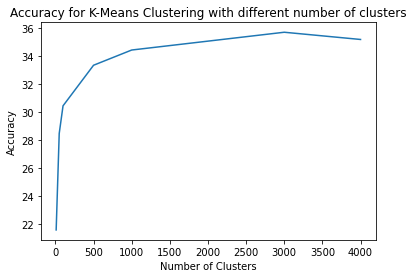

In [ ]:
accuracy = [acc_10, acc_50, acc_100, acc_500, acc_1000, acc_3000, acc_4000]
n_cluster = [10,50,100,500,1000,3000,4000]

plt.plot(n_cluster,accuracy)
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Accuracy for K-Means Clustering with different number of clusters')

plt.show()